In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def f(x):
    return 3*x**2 - 4*x + 5

In [5]:
f(3.0)

20.0

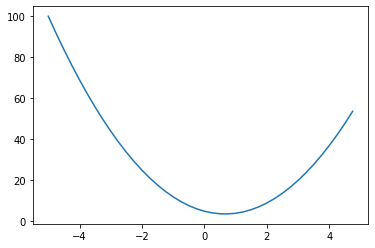

In [6]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [7]:
h = 0.000000001
x = 2/3
(f(x + h) - f(x))/h

0.0

In [8]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [9]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0
d1 = a*b + c

c += h

d2 = a*b + c

print("d1", d1)
print("d2", d2)
print("slope", (d2 - d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [22]:
class Value:
    def __init__(self, data, _children=(), _op='', label="") -> None:
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self) -> str:
        return f"Value({self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)

        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other - 1)) * out.grad

        out._backward = _backward
        return out
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __rtruediv__(self, other):
        return other * self**-1
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return other + (-self)


    def tanh(self):
        x = self.data
        t = math.tanh(x)
        out = Value(t, (self,), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [11]:
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
a - b

Value(5.0)

In [12]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))

        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot    

In [13]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')

x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1+x2w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'
o.backward()

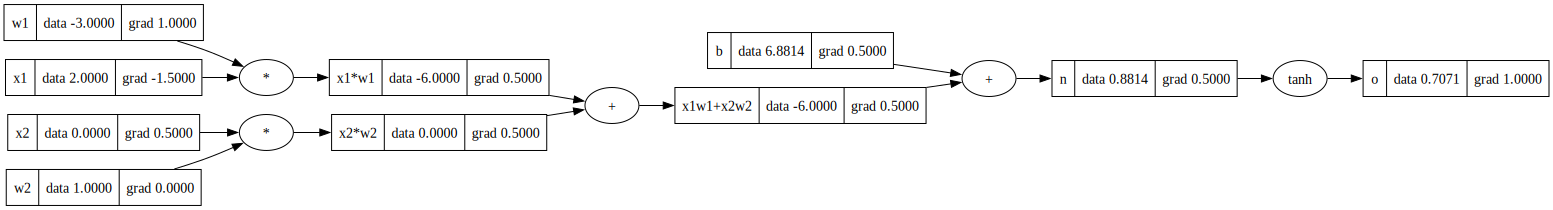

In [14]:
draw_dot(o)

In [15]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')

x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1+x2w2'
n = x1w1x2w2 + b; n.label = 'n'
# -------------------
e = (2*n).exp()
o = (e - 1) / (e + 1)
# o = ((2*n).exp()-1) / ((2*n).exp()+1)
# -------------------
e.label = 'e'
o.label = 'o'
o.backward()

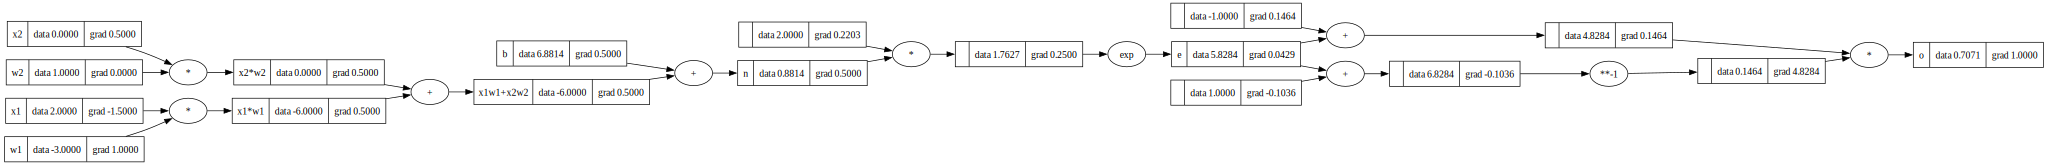

In [16]:
draw_dot(o)

In [17]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')

x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1+x2w2'
n = x1w1x2w2 + b; n.label = 'n'
# -------------------
# e = (2*n).exp()
# o = (e - 1) / (e + 1)
o = ((2*n).exp()-1) / ((2*n).exp()+1)
# -------------------
# e.label = 'e'
o.label = 'o'
o.backward()

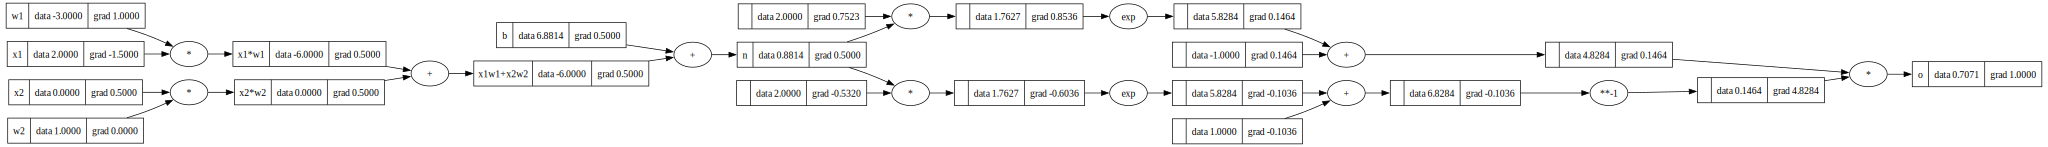

In [80]:
draw_dot(o)

In [1]:
import torch

x1 = torch.tensor([2.0]).double()               ; x1.requires_grad = True
x2 = torch.tensor([0.0]).double()               ; x2.requires_grad = True
w1 = torch.tensor([-3.0]).double()              ; w1.requires_grad = True
w2 = torch.tensor([1.0]).double()               ; w2.requires_grad = True
b = torch.tensor([6.8813735870195432]).double() ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print("-------------------")
print("x2", x2.grad.item())
print("w2", w2.grad.item())
print("x1", x1.grad.item())
print("w1", w1.grad.item())

0.7071066904050358
-------------------
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [41]:
import random


class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]
    
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(sz)-1)]

    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x
    
    def parameters(self):
        return [p for l in self.layers for p in l.parameters()]

In [115]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(-0.5650704007284815)

In [44]:
len(n.parameters())

41

In [105]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0]


In [159]:
for k in range(20):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])

    # zero out gradients
    for p in n.parameters():
        p.grad = 0.0

    # backward pass
    loss.backward()

    # update
    for p in n.parameters():
        p.data += -0.05 * p.grad
    
    print(k, loss.data)
    

0 1.5205591380893346e-05
1 1.5205033345652185e-05
2 1.5204475351114845e-05
3 1.520391739727856e-05
4 1.5203359484137956e-05
5 1.5202801611688916e-05
6 1.5202243779926754e-05
7 1.520168598884659e-05
8 1.5201128238445063e-05
9 1.5200570528717403e-05
10 1.5200012859658302e-05
11 1.5199455231264666e-05
12 1.5198897643530974e-05
13 1.5198340096453345e-05
14 1.5197782590026295e-05
15 1.5197225124247163e-05
16 1.5196667699110684e-05
17 1.5196110314612278e-05
18 1.519555297074721e-05
19 1.5194995667512285e-05
20 1.519443840490104e-05
21 1.5193881182911117e-05
22 1.5193324001537243e-05
23 1.5192766860774554e-05
24 1.519220976061901e-05
25 1.5191652701066806e-05
26 1.5191095682112367e-05
27 1.519053870375189e-05
28 1.5189981765980591e-05
29 1.5189424868794646e-05
30 1.5188868012189177e-05
31 1.5188311196160188e-05
32 1.5187754420702862e-05
33 1.5187197685812909e-05
34 1.5186640991485478e-05
35 1.5186084337716993e-05
36 1.5185527724502243e-05
37 1.5184971151837075e-05
38 1.5184414619717214e-05
39

In [161]:
ypred

[Value(0.9978507978994821),
 Value(-0.9991134508466267),
 Value(-0.9979463663252673),
 Value(0.997868472171925)]